In [10]:
import pandas as pd
import spacy
from google.colab import drive

In [11]:
drive.mount("/content/Drive")

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [12]:
df = pd.read_parquet("/content/Drive/MyDrive/PLN/projeto-pln/dataset_processed.parquet")

In [13]:
df.head()

,articles,label
0,news justice david souter retirement adds anot...,1
1,let face goal go deer hunting really want spen...,1
2,worry temporary new sheriff takes next month a...,1
3,r daily basis like oral contraception rhythm w...,1
4,update sen kent conrad n denied bloomberg stor...,1


In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [16]:
df.value_counts('label')

,count
label,
0,22554
1,22554


In [17]:
sampled_df = pd.concat([
    df[df['label'] == 0].sample(n=22554, random_state=42),
    df[df['label'] == 1].sample(n=22554, random_state=42)
])

In [18]:
sampled_df.reset_index(drop=True, inplace=True)

In [19]:
print(sampled_df.value_counts('label'))

label
0    22554
1    22554
Name: count, dtype: int64


In [20]:
df = sampled_df

In [21]:
df.head()

,articles,label
0,david martosko us political editor com washing...,0
1,indeed obamacare passed 2009 without single re...,0
2,former alaska governor sarah palin blasted hyp...,0
3,discover thomson david ingram 5 min read new y...,0
4,uc berkeley welcoming place conservative stude...,0


### Modelo LSTM

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [23]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [24]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['articles'])

In [25]:
tokenizer.fit_on_texts(test_df['articles'])

In [26]:
X_train = tokenizer.texts_to_sequences(train_df['articles'])
X_train = pad_sequences(X_train, maxlen=100)

X_test = tokenizer.texts_to_sequences(test_df['articles'])
X_test = pad_sequences(X_test, maxlen=100)

In [27]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df['label'])
y_train = to_categorical(y_train)

y_test = label_encoder.transform(test_df['label'])
y_test = to_categorical(y_test)

In [28]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=200),
    LSTM(200, dropout=0.5, recurrent_dropout=0.5),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.5))
])

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # tô usando entropia cruzada como visto nas aulas, e adam pois ele é muito bom.

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia final do modelo: {accuracy}')

Epoch 1/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 279s 543ms/step - accuracy: 0.6970 - loss: 1.2076 - val_accuracy: 0.7592 - val_loss: 0.5107
Epoch 2/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 289s 479ms/step - accuracy: 0.7850 - loss: 0.4903 - val_accuracy: 0.7678 - val_loss: 0.4911
Epoch 3/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 258s 471ms/step - accuracy: 0.8186 - loss: 0.4466 - val_accuracy: 0.7684 - val_loss: 0.4941
Epoch 4/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 260s 467ms/step - accuracy: 0.8299 - loss: 0.4214 - val_accuracy: 0.7686 - val_loss: 0.5015
Epoch 5/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 262s 467ms/step - accuracy: 0.8419 - loss: 0.4057 - val_accuracy: 0.7675 - val_loss: 0.4942
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7749 - loss: 0.4888
Acurácia final do modelo: 0.7737752199172974


### Visualizando métricas de acurácia

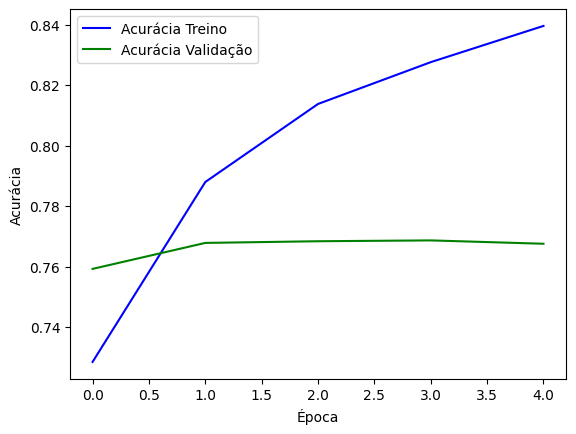

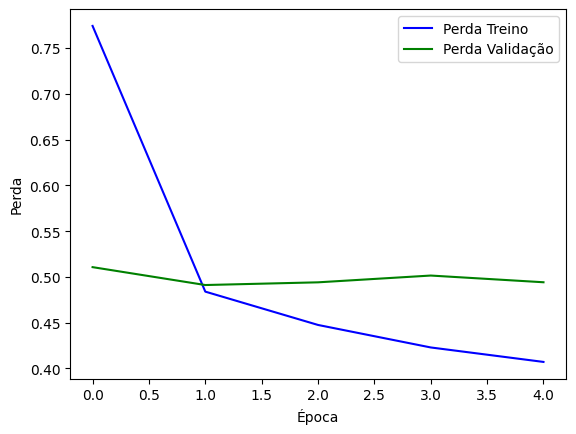

In [40]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Acurácia Treino', color="b")
plt.plot(val_accuracy, label='Acurácia Validação', color="g")
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(train_loss, label='Perda Treino', color="b")
plt.plot(val_loss, label='Perda Validação', color="g")
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

### Matriz de confusão

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

282/282 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step


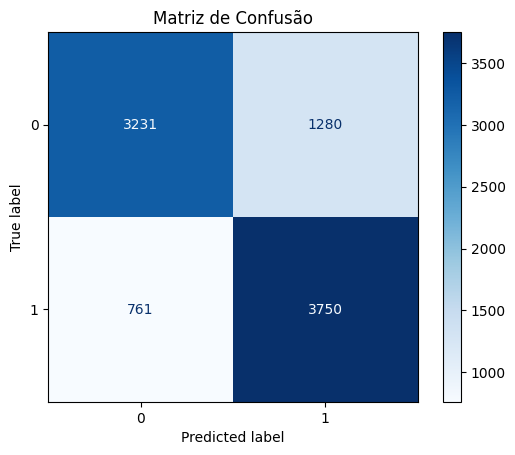

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

plot_confusion_matrix(y_test_classes, y_pred_classes, label_encoder.classes_)

### Exemplo de classificação

In [33]:
def show_classification_examples(X_test, y_test_classes, y_pred_classes, articles):
    correct_idx = np.where(y_test_classes == y_pred_classes)[0]
    incorrect_idx = np.where(y_test_classes != y_pred_classes)[0]

    if len(correct_idx) > 0:
        idx = correct_idx[0]
        print(f"Exemplo classificado corretamente:\nArtigo: {articles[idx]}\nClasse verdadeira: {label_encoder.classes_[y_test_classes[idx]]}\nClasse predita: {label_encoder.classes_[y_pred_classes[idx]]}")

    print("\n")

    if len(incorrect_idx) > 0:
        idx = incorrect_idx[0]
        print(f"Exemplo classificado incorretamente:\nArtigo: {articles[idx]}\nClasse verdadeira: {label_encoder.classes_[y_test_classes[idx]]}\nClasse predita: {label_encoder.classes_[y_pred_classes[idx]]}")

show_classification_examples(X_test, y_test_classes, y_pred_classes, test_df['articles'].values)

Exemplo classificado corretamente:
Artigo: paris mayor anne hidalgo took another shot fox news interview aired week saying channel reporting muslim go zones city lie serious time hidalgo spoke cnn city planned lawsuit fox news coverage supposed go zones wake terror attacks islamic extremists earlier year paris fox eventually issued multiple corrections said credible information support idea non muslims allowed parts england france world dangerously tip seen hidalgo said according cnn translation accept type talk adds difficulty though explain details lawsuit fox said city took legal action paris high court said remained angry fox reporting economic consequences united states suddenly become afraid paris fox news lie hidalgo said according cnn opinion legitimate criticism democracy real criticism normal lie serious time like fox stigmatized portion population wanted show something exist despite hidalgo talk lawsuit however fox news told washington post friday yet see court documents wat